In [1]:
import findspark
findspark.init()

# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my app").master("local").getOrCreate()

# get context from the session
sc = spark.sparkContext

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Misc

In [3]:
def create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
    if not record:
        yield record

In [4]:
def create_dataset(N, D=10000):
    """
    N개의 집합 데이터 생성 (D = 사전 사이즈)
    """
    
    while True:
        s = np.random.default_rng().zipf(1.2, N * 10 * 10)
        dataset = list(create_setdata(s[s<D]))
        if len(dataset) >=N:
            break

    ids = range(N)
    return [ (i, s) for i, s in zip(ids, dataset[:N]) ]

In [5]:
def compute_similarity(s1, s2):
    """
    주어진 2개 집합의 Jaccard similarity 계산
    """
    
    return float(len(s1 & s2)) / float(len(s1 | s2))

In [6]:
def distinct_pairs(l):
    l.sort()
    for i,e1 in enumerate(l):
        for j,e2 in enumerate(l):
            if i<j:
                yield ((e1, e2), 1)

# Test

In [9]:
N=1600
thres=0.6
minSize = 5

In [10]:
dataset = create_dataset(N)

In [11]:
setSize = sc.broadcast([ len(s) for i,s in dataset ])

In [12]:
res = sc.parallelize(dataset)\
        .filter(lambda t: len(t[1]) >= minSize ) \
        .flatMap(lambda t: [ (i, t[0]) for i in t[1] ])\
        .groupByKey().mapValues(list)\
        .flatMap(lambda t: distinct_pairs(t[1]))\
        .reduceByKey(lambda a,b:a+b)\
        .filter(lambda t: t[1] >= (thres / (1. + thres) * (setSize.value[t[0][0]] + setSize.value[t[0][1]])) )\
        .map(lambda t: t[0])

In [13]:
test1 = sorted(res.collect())

In [14]:
test2 = list()
for s1 in dataset:
    if len(s1[1]) >= minSize:
        for s2 in dataset:
            if len(s2[1]) >= minSize:
                if s1[0] < s2[0] and compute_similarity(s1[1], s2[1]) >= thres:
                    test2.append((s1[0], s2[0]))

In [15]:
assert test1 == test2, "fail"

In [16]:
Ns = [200, 400, 800, 1600]
Ts = [0.6, 0.7, 0.8, 0.9]

In [17]:
execution_time = list()
for N in Ns:
    ts = list()
    local = create_dataset(N)
    for thres in Ts:
        start_time = time.time()
        res = sc.parallelize(local)\
            .filter(lambda t: len(t[1]) >= minSize ) \
            .flatMap(lambda t: [ (i, t[0]) for i in t[1] ])\
            .groupByKey().mapValues(list)\
            .flatMap(lambda t: distinct_pairs(t[1]))\
            .reduceByKey(lambda a,b:a+b)\
            .filter(lambda t: t[1] >= (thres / (1. + thres) * (setSize.value[t[0][0]] + setSize.value[t[0][1]])) )\
            .count()
        ts.append(time.time() - start_time)
    execution_time.append(ts)

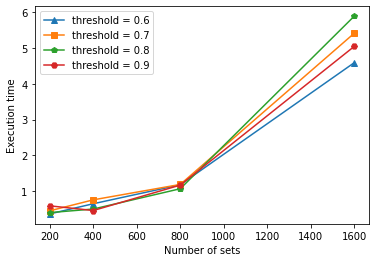

In [20]:
execution_time = np.array(execution_time).T.tolist()

markers=['^', 's', 'p', 'H']
labels = [ 'threshold = {}'.format(t) for t in Ts ]
for ts, m, lb in zip(execution_time, markers, labels):
    plt.plot(Ns, ts, linestyle='-', marker=m, label=lb)
#plt.ylim([10, 20])
plt.xlabel("Number of sets")
plt.ylabel("Execution time")
plt.legend(loc='best')
plt.show()

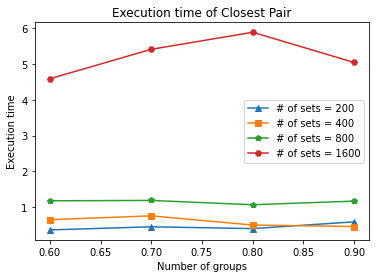

In [21]:
execution_time = np.array(execution_time).T.tolist()

markers=['^', 's', 'p', 'H']
labels = [ '# of sets = {}'.format(n) for n in Ns ]
for ts, m, lb in zip(execution_time, markers, labels):
    plt.plot(Ts, ts, linestyle='-', marker=m, label=lb)
plt.xlabel("Number of groups")
plt.ylabel("Execution time")
plt.title("Execution time of Closest Pair")
#plt.ylim([10, 30])
plt.legend(loc='best')
plt.show()